# Installs and Import Data

In [1]:
! pip install -q torch==1.4.0
! pip install -q torchvision==0.5.0
! pip install -q kornia==0.2.2
! pip install -q fastcore
! pip install -q fastai2
! pip install -q git+https://github.com/thomasbrandon/mish-cuda
! git clone https://github.com/pgmmpk/tfrecord.git

     |████████████████████████████████| 194kB 4.8MB/s 


In [0]:
!wget 'insert flowers url here' -O 'flowers.zip'

In [0]:
! unzip -q flowers.zip -d flowers

# Imports

In [2]:
%tensorflow_version 1.x
from fastai2.vision.all import *
import tensorflow as tf
from tfrecord.tfrecord import *
from mish_cuda import MishCuda
import gc
import kornia

TensorFlow 1.x selected.


# Setup Dataloader

In [0]:
path = Path('flowers/tfrecords-jpeg-224x224')

train_fnames = get_files(path/'train', extensions='.tfrec')
test_fnames = get_files(path/'val', extensions='.tfrec')

In [0]:
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

In [0]:
data = []
for name in train_fnames+test_fnames:
  r = Reader(str(name), unpack_sample)
  for sample in r:
    data.append([sample['image'][0], sample['class'][0]])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [0]:
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

splitter = IndexSplitter(range(12753, len(data)))

def get_items(*args, **kwargs): return data

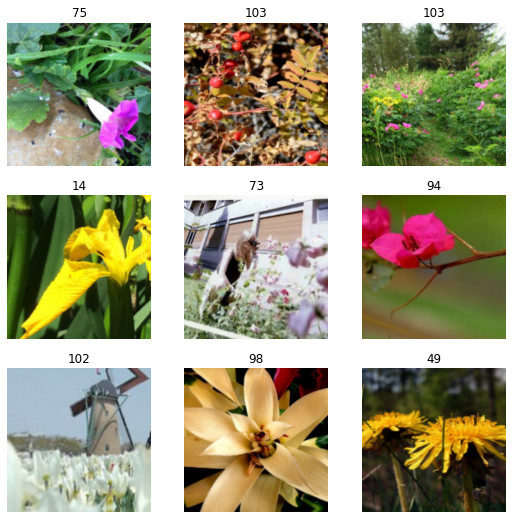

In [0]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[RandomResizedCrop(224, min_scale=0.7)],
                  batch_tfms=[*aug_transforms(do_flip=True)])

dls = block.dataloaders([''], bs=64)

dls.show_batch()

# MK-ResNeXt-50

MK-ResNeXt (Mixed Depthwise Convolutional Kernel or Multi-Kernel RexNeXt) is a modification of fast.ai's X-ResNeXt using mixed depthwise convolutions (MDConv) proposed by [Mingxing Tan & Quoc V. Le](https://arxiv.org/abs/1907.09595/).

This notebook contains two early variants, D & E. MK-ResNeXt-D only contains MDConv in the middle layer of the ResNeXt bottleneck, while MK-ResNeXt-E also has a [3,5] MDConv in the first layer of Bottlenecks with a [3,5,7,9] middle MDConv. If applicable, both move the Squeeze and Excite layer to be directly after the MDConv layer, that is before the last Conv layer in the Bottleneck, but remain in the standard location for non-MDConv Bottlenecks.


## Common

In [0]:
# GeM Pool from https://github.com/filipradenovic/cnnimageretrieval-pytorch
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [0]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
def replace_model_layer(model, layer_type_old, new_layer):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = replace_model_layer(module, layer_type_old, new_layer)

        if type(module) == layer_type_old:
            layer_old = module
            model._modules[name] = new_layer

    return model

In [0]:
from fastai2.layers import *
from fastai2.imports import *
from fastai2.torch_imports import *
from fastai2.torch_core import *
from torch.nn.utils import weight_norm, spectral_norm
from fastai2.layers import _conv_func

# adapted from https://github.com/romulus0914/MixNet-PyTorch
class MDConv(Module):
    "Create a mixed depthwise convolutional (`ni` to `nf`) layer."
    def __init__(self, ni, nf, ks, stride=1, groups=1, bias=None, padding=None, ndim=2, transpose=False, **kwargs):
        conv_func = _conv_func(ndim, transpose=transpose)

        num_ks = len(ks)
        self.nis = self._split(ni, num_ks)
        nfs = self._split(nf, num_ks)

        self.md_conv_layers = nn.ModuleList()
        for i in range(num_ks):
            self.md_conv_layers.append(conv_func(
                self.nis[i], 
                nfs[i], 
                kernel_size=ks[i], 
                bias=bias, 
                stride=stride, 
                padding=((ks[i]-1)//2 if not transpose else 0),
                groups=groups,
                **kwargs)
            )

    def _split(self, total, groups):
        split = [total//groups] * groups
        split[0] += total - sum(split)
        return split

    def forward(self, x):
        x = torch.split(x, self.nis, dim=1)
        x = [conv(y) for conv, y in zip(self.md_conv_layers, x)]
        x = torch.cat(x, dim=1)
        return x

class MDConvLayer(nn.Sequential):
    "Create a sequence of mixed depthwise convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv = MDConv(ni, nf, ks=ks, bias=bias, stride=stride, padding=padding, ndim=ndim, transpose=transpose, **kwargs)
        act = None if act_cls is None else act_cls()
        for md_conv in conv.md_conv_layers:
            init_linear(md_conv, act, init=init, bias_std=bias_std)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act is not None: act_bn.append(act)
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)
        
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

## MK-ResNeXt-D

In [0]:
class MKResNeXtDBlock(Module):
    "MKResNeXtDBlock block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, groups=32, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=[3],
                 base_width=4, pool=AvgPool, pool_first=True, se_sz=2, **kwargs):
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        ks_len = len(ks)
        base_width = max(base_width, ks_len)
        if nh2 is None: nh2 = math.floor(nf * (base_width / 64)) * groups
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        convpath  = [ConvLayer(ni,  nh1, 1, **k0),
                     MDConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0),
                     SEModule(nh2, reduction=reduction, act_cls=act_cls),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)
        ] if reduction and se_sz>=ks_len and ks_len!=1 else [
                     ConvLayer(ni,  nh1, 1, **k0),
                     MDConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0) if len(ks)>1 else ConvLayer(nh1, nh2, ks[0], stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction and se_sz>=ks_len and ks_len==1: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(2, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()
        
    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

In [0]:
class MKResNeXtD(nn.Sequential):
    @delegates(MKResNeXtDBlock)
    def __init__(self, block, expansion, layers, p=0.0, c_in=3, n_out=1000, stem_szs=(24,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, ks=None, se_sz=2, 
                 final_pool=nn.AdaptiveAvgPool2d(1), **kwargs):
        store_attr(self, 'block,expansion,act_cls')
        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], stride=2 if i==0 else 1, act_cls=act_cls)
                for i in range(3)]

        block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, ks, se_sz, **kwargs)

        super().__init__(
            *stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            final_pool, Flatten(), nn.Dropout(p),
            nn.Linear(block_szs[-1]*expansion, n_out),
        )
        init_cnn(self)

    def _make_blocks(self, layers, block_szs, sa, ks, se_sz, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l, ks=ks[i], se_sz=se_sz,
                                 stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, ks, se_sz, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, ks=ks, se_sz=se_sz, **kwargs)
              for i in range(blocks)])

def mk_resnext50d(n_out=1000, pretrained=False, se_sz=2, **kwargs):   
    return MKResNeXtD(MKResNeXtDBlock, 4, [3, 4,  6, 3], groups=32, n_out=n_out, se_sz=se_sz, **kwargs)

def se_mk_resnext50d(n_out=1000, pretrained=False, reduction=8, se_sz=2, **kwargs):   
    return MKResNeXtD(MKResNeXtDBlock, 4, [3, 4,  6, 3], groups=32, reduction=reduction, se_sz=se_sz, n_out=n_out, **kwargs)

## MK-ResNeXt-E

In [0]:
class MKResNeXtEBlock(Module):
    "MKResNeXtEBlock block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, groups=32, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=[3],
                 iks=[3,5], base_width=4, pool=AvgPool, pool_first=True, se_sz=2, **kwargs):
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        ks_len = len(ks)
        base_width = max(base_width, ks_len)
        if nh2 is None: nh2 = math.floor(nf * (base_width / 64)) * groups
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        first_layer = MDConvLayer(ni, nh1, ks=iks, **k0) if ks_len > 2 else ConvLayer(ni, nh1, 1, **k0)
        convpath  = [first_layer,
                     MDConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0),
                     SEModule(nh2, reduction=reduction, act_cls=act_cls),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)
        ] if reduction and se_sz>=ks_len and ks_len!=1 else [
                     first_layer,
                     MDConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0) if ks_len>1 else ConvLayer(nh1, nh2, ks[0], stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction and se_sz>=ks_len and ks_len==1: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(2, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()
        
    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

In [0]:
class MKResNeXtE(nn.Sequential):
    @delegates(MKResNeXtEBlock)
    def __init__(self, block, expansion, layers, p=0.0, c_in=3, n_out=1000, stem_szs=(24,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, ks=None, iks=[3,5], 
                 final_pool=nn.AdaptiveAvgPool2d(1), **kwargs):
        store_attr(self, 'block,expansion,act_cls')

        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], stride=2 if i==0 else 1, act_cls=act_cls)
                for i in range(3)]

        block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, ks, iks, **kwargs)

        super().__init__(
            *stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            final_pool, Flatten(), nn.Dropout(p),
            nn.Linear(block_szs[-1]*expansion, n_out),
        )
        init_cnn(self)

    def _make_blocks(self, layers, block_szs, sa, ks, iks, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l, ks=ks[i], iks=iks,
                                 stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, ks, iks, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, ks=ks, iks=iks, **kwargs)
              for i in range(blocks)])

def mk_resnext50e(n_out=1000, pretrained=False, iks=[3,5], **kwargs):   
    return MKResNeXtE(MKResNeXtEBlock, 4, [3, 4,  6, 3], groups=32, iks=iks, n_out=n_out, **kwargs)

def se_mk_resnext50e(n_out=1000, pretrained=False, iks=[3,5], reduction=8, **kwargs):   
    return MKResNeXtE(MKResNeXtEBlock, 4, [3, 4,  6, 3], groups=32, iks=iks, reduction=reduction, n_out=n_out, **kwargs)

In [26]:
mk_resnext50d(ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

MKResNeXtD(
  (0): ConvLayer(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): MKResNeXtDBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# MK-ResNeXt-50D

## Exp 1: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]]

### Exp 1.1: No SE - 0.78897

SuggestedLRs(lr_min=0.0019596852362155914, lr_steep=0.0012200333876535296)

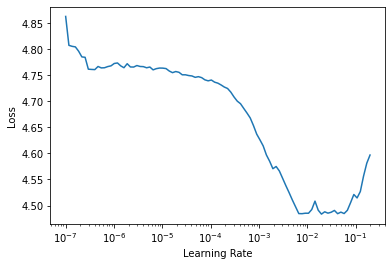

In [0]:
model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

32233

In [0]:
results = []
for i in range(3):
    model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.131058,2.872582,0.378502,02:40
1,2.615683,2.535346,0.481681,02:40
2,2.232554,2.203652,0.582705,02:39
3,1.946522,2.076089,0.631465,02:39
4,1.554285,1.597013,0.791487,02:38


epoch,train_loss,valid_loss,accuracy,time
0,3.162586,3.212822,0.282866,02:38
1,2.609028,2.522144,0.500269,02:38
2,2.213277,2.206441,0.577317,02:38
3,1.939450,2.023155,0.651670,02:39
4,1.561933,1.571475,0.800108,02:38


epoch,train_loss,valid_loss,accuracy,time
0,3.134031,2.867328,0.381735,02:38
1,2.609223,2.538993,0.486800,02:38
2,2.223936,2.253616,0.573006,02:38
3,1.999524,2.115231,0.617188,02:39
4,1.590311,1.629477,0.775323,02:39


In [0]:
print(results)

[0.7914870977401733, 0.8001077771186829, 0.7753232717514038]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.78897
Accuracy Std: 0.01027


### Exp 1.2: SE reduction=8 - 0.79840

SuggestedLRs(lr_min=0.004237744957208633, lr_steep=0.004889663774520159)

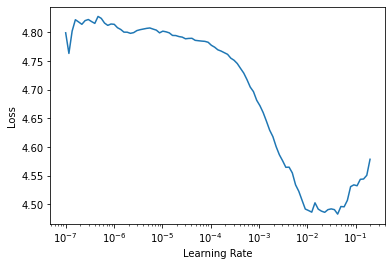

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

10987

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.081191,2.887338,0.376886,02:42
1,2.530528,2.479006,0.504580,02:42
2,2.194539,2.264282,0.576239,02:42
3,1.900821,2.077576,0.641164,02:42
4,1.524418,1.554432,0.807381,02:42


epoch,train_loss,valid_loss,accuracy,time
0,3.107232,3.258859,0.287446,02:42
1,2.573764,2.445432,0.505657,02:42
2,2.229944,2.185004,0.585668,02:42
3,1.946082,2.124929,0.607489,02:42
4,1.556328,1.589468,0.787177,02:43


epoch,train_loss,valid_loss,accuracy,time
0,3.101597,2.831525,0.379041,02:43
1,2.551093,2.395676,0.515894,02:43
2,2.203471,2.470099,0.506196,02:43
3,1.933794,1.892568,0.689655,02:42
4,1.537340,1.574953,0.800647,02:42


In [0]:
print(results)

[0.8073814511299133, 0.7871767282485962, 0.8006465435028076]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79840
Accuracy Std: 0.00840


### Exp 1.3: SE reduction=16 - 0.80163

SuggestedLRs(lr_min=0.004237744957208633, lr_steep=0.005705171264708042)

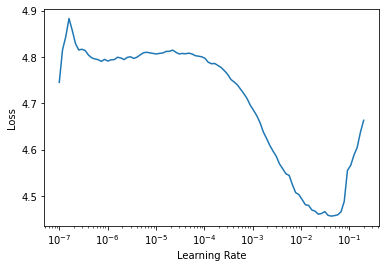

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

15372

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.099263,2.800431,0.387123,02:43
1,2.543286,2.605079,0.463093,02:43
2,2.176954,2.265455,0.577856,02:43
3,1.901389,1.952395,0.673491,02:42
4,1.524677,1.545205,0.806573,02:42


epoch,train_loss,valid_loss,accuracy,time
0,3.066438,2.845023,0.360991,02:42
1,2.569516,2.459882,0.501347,02:42
2,2.173615,2.246235,0.557651,02:42
3,1.884658,1.953820,0.670528,02:42
4,1.515011,1.552411,0.802263,02:42


epoch,train_loss,valid_loss,accuracy,time
0,3.091161,2.947154,0.359375,02:42
1,2.555542,2.413019,0.523707,02:42
2,2.197673,2.224417,0.574084,02:42
3,1.906978,1.954284,0.666218,02:42
4,1.534627,1.573427,0.796067,02:42


In [0]:
print(results)

[0.8065732717514038, 0.8022629022598267, 0.7960668206214905]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.80163
Accuracy Std: 0.00431


### Exp 1.4: GeM SE reduction=8 - 0.79741

SuggestedLRs(lr_min=0.0006656690966337919, lr_steep=0.0010456395102664828)

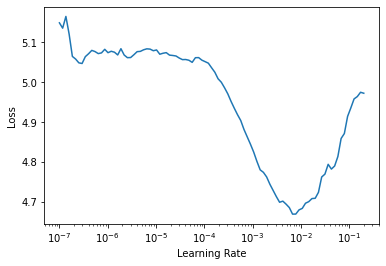

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]], final_pool=GeM())

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

11544

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]], final_pool=GeM())

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.170457,2.853091,0.390894,02:42
1,2.539930,2.395462,0.511853,02:42
2,2.175602,2.305846,0.542565,02:42
3,1.888728,1.942493,0.659213,02:43
4,1.480504,1.532804,0.799838,02:42


epoch,train_loss,valid_loss,accuracy,time
0,3.217903,2.983235,0.340787,02:42
1,2.564734,2.353374,0.528825,02:43
2,2.186382,2.135882,0.594558,02:43
3,1.911392,2.045563,0.637931,02:43
4,1.493214,1.542539,0.791756,02:43


epoch,train_loss,valid_loss,accuracy,time
0,3.179340,2.930072,0.351562,02:42
1,2.568961,2.547324,0.464978,02:42
2,2.169629,2.262221,0.559806,02:42
3,1.918782,1.932079,0.661907,02:42
4,1.511901,1.537838,0.800647,02:42


In [0]:
print(results)

[0.7998383641242981, 0.7917564511299133, 0.8006465435028076]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79741
Accuracy Std: 0.00401


### Exp 1.4: GeM SE reduction=16 - 0.78942

SuggestedLRs(lr_min=0.0009062286466360092, lr_steep=0.0006582834175787866)

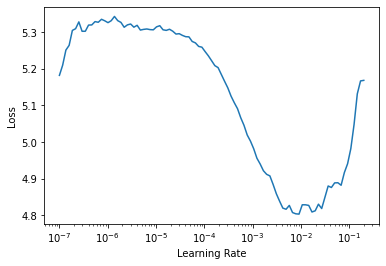

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]], final_pool=GeM())
model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16827

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]], final_pool=GeM())
    model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.200248,3.015341,0.342672,02:47
1,2.589318,2.426359,0.502694,02:47
2,2.247193,2.367787,0.518858,02:47
3,1.956815,1.989712,0.646013,02:47
4,1.528177,1.583043,0.780172,02:47


epoch,train_loss,valid_loss,accuracy,time
0,3.183484,2.918961,0.385237,02:47
1,2.578427,2.457922,0.503233,02:47
2,2.200759,2.372863,0.525054,02:47
3,1.937668,2.040589,0.632812,02:48
4,1.513310,1.558571,0.793103,02:47


epoch,train_loss,valid_loss,accuracy,time
0,3.220380,2.956987,0.361261,02:47
1,2.603270,2.419646,0.498114,02:48
2,2.200634,2.199623,0.580550,02:48
3,1.898057,1.894288,0.676185,02:48
4,1.489880,1.546054,0.794989,02:48


In [0]:
print(results)

[0.7801724076271057, 0.7931034564971924, 0.7949892282485962]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.78942
Accuracy Std: 0.00659


## Exp 2: ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]]

### Exp 2.1: Without SE - 0.79328

SuggestedLRs(lr_min=0.004237744957208633, lr_steep=0.005705171264708042)

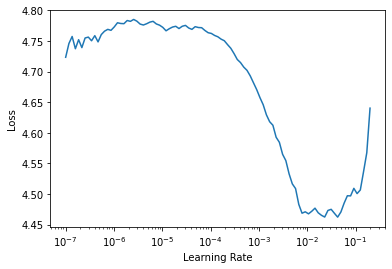

In [0]:
model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

15230

In [0]:
results = []
for i in range(3):
    model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.132193,2.824162,0.390625,02:55
1,2.579999,2.423309,0.522360,02:55
2,2.184946,2.191146,0.589440,02:55
3,1.897697,1.938831,0.675377,02:55
4,1.509189,1.558589,0.804418,02:55


epoch,train_loss,valid_loss,accuracy,time
0,3.189901,2.873252,0.369343,02:55
1,2.604450,2.487092,0.500269,02:55
2,2.209088,2.230499,0.571390,02:55
3,1.912532,2.022715,0.643588,02:55
4,1.545392,1.588192,0.786369,02:55


epoch,train_loss,valid_loss,accuracy,time
0,3.127140,2.932294,0.357220,02:55
1,2.605645,2.512736,0.497037,02:55
2,2.221488,2.281830,0.565733,02:55
3,1.954848,2.002135,0.658136,02:54
4,1.562351,1.598610,0.789062,02:54


In [0]:
print(results)

[0.8044180870056152, 0.7863685488700867, 0.7890625]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79328
Accuracy Std: 0.00795


### Exp 2.2: SE reduction=8 - 0.80029

SuggestedLRs(lr_min=0.0022865252569317816, lr_steep=0.004190726205706596)

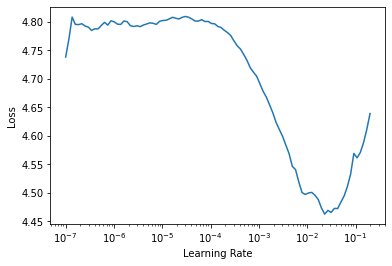

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16902

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.137748,3.044015,0.327047,02:58
1,2.540962,2.452679,0.506465,02:58
2,2.152608,2.221294,0.582705,02:59
3,1.900231,2.091634,0.619343,02:59
4,1.512109,1.551651,0.805765,02:59


epoch,train_loss,valid_loss,accuracy,time
0,3.116796,3.022878,0.353179,02:59
1,2.552974,2.522076,0.504310,02:59
2,2.203256,2.330986,0.567619,02:59
3,1.966062,1.955894,0.672953,03:00
4,1.539903,1.576420,0.791218,03:00


epoch,train_loss,valid_loss,accuracy,time
0,3.145539,2.791801,0.391972,02:59
1,2.566786,2.689295,0.440194,02:59
2,2.197793,2.173754,0.600754,02:59
3,1.913171,1.957849,0.666218,02:59
4,1.525738,1.555820,0.803879,03:00


In [0]:
print(results)

[0.8057650923728943, 0.7912176847457886, 0.8038793206214905]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.80029
Accuracy Std: 0.00646


### Exp 2.3: SE reduction=16 - 0.79140

SuggestedLRs(lr_min=0.004944524168968201, lr_steep=0.004190726205706596)

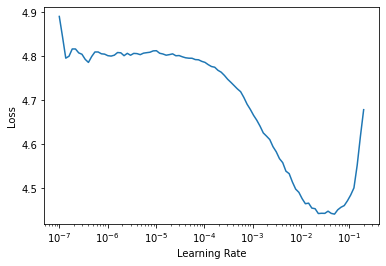

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16624

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.100083,3.085944,0.321121,02:59
1,2.513964,2.400274,0.529903,02:59
2,2.198481,2.379786,0.532058,02:59
3,1.878835,2.064653,0.633890,02:59
4,1.514839,1.548730,0.798222,02:59


epoch,train_loss,valid_loss,accuracy,time
0,3.094824,2.883683,0.372037,02:59
1,2.566957,2.590429,0.469828,02:59
2,2.218811,2.326116,0.542295,03:00
3,1.937459,2.133094,0.608567,03:00
4,1.562148,1.580146,0.797414,02:59


epoch,train_loss,valid_loss,accuracy,time
0,3.172685,2.939341,0.350216,02:59
1,2.621538,2.489657,0.483028,02:58
2,2.220941,2.280096,0.549838,02:58
3,1.956289,2.016449,0.645474,02:59
4,1.592690,1.622737,0.778556,02:59


In [0]:
print(results)

[0.798222005367279, 0.7974137663841248, 0.7785560488700867]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79140
Accuracy Std: 0.00909


### Exp 2.4: GeM SE reduction=8 - 0.78538

SuggestedLRs(lr_min=0.0009062286466360092, lr_steep=0.0008961739367805421)

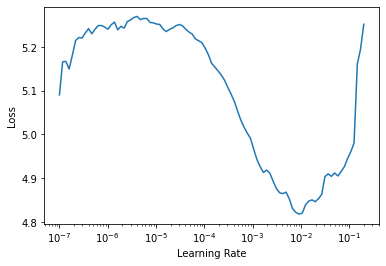

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]], final_pool=GeM())
model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16781

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]], final_pool=GeM())
    model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.223522,2.971040,0.361800,03:09
1,2.591107,2.660346,0.456627,03:09
2,2.203333,2.128979,0.606142,03:09
3,1.929933,1.952006,0.663254,03:09
4,1.520321,1.575990,0.788254,03:09


epoch,train_loss,valid_loss,accuracy,time
0,3.163568,2.784259,0.394935,03:09
1,2.565473,2.484458,0.488685,03:08
2,2.190134,2.185517,0.581088,03:08
3,1.909445,2.027318,0.644935,03:08
4,1.496342,1.566927,0.794181,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.161209,2.999253,0.342672,03:08
1,2.591836,2.478346,0.481412,03:08
2,2.224367,2.263313,0.555226,03:09
3,1.961842,2.069900,0.615840,03:09
4,1.557856,1.598541,0.773707,03:09


In [0]:
print(results)

[0.7882543206214905, 0.7941810488700867, 0.7737069129943848]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.78538
Accuracy Std: 0.00860


### Exp 2.5: GeM SE reduction=16 - 0.79077

SuggestedLRs(lr_min=0.0016795642673969268, lr_steep=0.00026090038591064513)

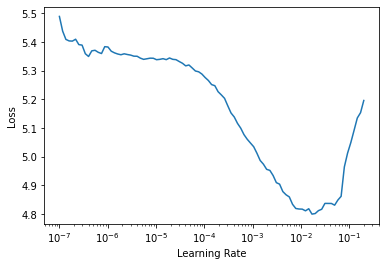

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]], final_pool=GeM())
model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16851

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]], final_pool=GeM())
    model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())
    
    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.239142,2.926906,0.359375,03:08
1,2.612876,2.522703,0.464978,03:08
2,2.216943,2.228641,0.557112,03:08
3,1.948508,1.922192,0.667026,03:09
4,1.525795,1.570192,0.790679,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.195214,2.805297,0.390086,03:08
1,2.591542,2.450294,0.496767,03:08
2,2.194641,2.314263,0.534483,03:08
3,1.923259,1.950721,0.656519,03:08
4,1.504643,1.565577,0.788793,03:09


epoch,train_loss,valid_loss,accuracy,time
0,3.168002,2.850647,0.397629,03:08
1,2.579610,2.497006,0.484914,03:08
2,2.208498,2.254552,0.562231,03:09
3,1.938202,1.963201,0.659483,03:09
4,1.523473,1.562307,0.792834,03:09


In [0]:
print(results)

[0.790678858757019, 0.7887930870056152, 0.7928340435028076]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79077
Accuracy Std: 0.00165


## Exp 3: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]]

### Exp 3.1: Without SE - 0.79966

SuggestedLRs(lr_min=0.0026678763329982757, lr_steep=0.002638275967910886)

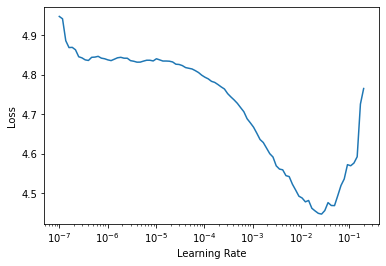

In [0]:
model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

14993

In [0]:
results = []
for i in range(3):
    model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.115774,2.883736,0.360183,02:36
1,2.613316,2.516108,0.484644,02:36
2,2.204204,2.387349,0.534213,02:37
3,1.973310,2.007838,0.650862,02:37
4,1.540220,1.581270,0.793103,02:37


epoch,train_loss,valid_loss,accuracy,time
0,3.157465,3.061708,0.308459,02:37
1,2.593348,2.511437,0.474946,02:36
2,2.214529,2.254337,0.560075,02:36
3,1.934308,2.051435,0.642511,02:36
4,1.518512,1.543030,0.806573,02:37


epoch,train_loss,valid_loss,accuracy,time
0,3.094499,2.910193,0.364763,02:37
1,2.548695,2.683783,0.463362,02:37
2,2.184021,2.171013,0.585668,02:37
3,1.932303,2.097544,0.619612,02:37
4,1.527999,1.563653,0.799300,02:37


In [0]:
print(results)

[0.7931034564971924, 0.8065732717514038, 0.7992995977401733]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79966
Accuracy Std: 0.00550


### Exp 3.2: SE reduction=8 - 0.78700

SuggestedLRs(lr_min=0.0010573712177574634, lr_steep=0.0022611559834331274)

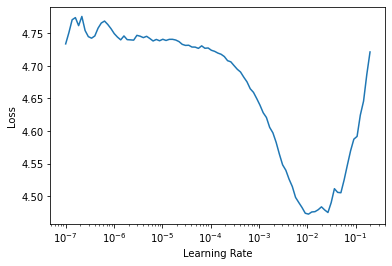

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8,  ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

14361

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.129592,2.868858,0.373384,02:41
1,2.559968,2.502149,0.475485,02:41
2,2.228199,2.302237,0.541756,02:41
3,1.959343,2.041416,0.644397,02:41
4,1.562678,1.602909,0.781789,02:42


epoch,train_loss,valid_loss,accuracy,time
0,3.084048,2.906799,0.369343,02:42
1,2.579665,2.461360,0.503772,02:42
2,2.221823,2.125398,0.617188,02:41
3,1.951982,2.036387,0.634698,02:41
4,1.555866,1.591077,0.788254,02:41


epoch,train_loss,valid_loss,accuracy,time
0,3.116148,2.816928,0.380388,02:41
1,2.580345,2.412722,0.518858,02:41
2,2.227971,2.359247,0.535291,02:41
3,1.957805,1.960557,0.666218,02:41
4,1.569346,1.583956,0.790948,02:41


In [0]:
print(results)

[0.7817887663841248, 0.7882543206214905, 0.7909482717514038]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.78700
Accuracy Std: 0.00384


### Exp 3.3: SE reduction=16 - 0.79185

SuggestedLRs(lr_min=0.0019596852362155914, lr_steep=0.0035916962660849094)

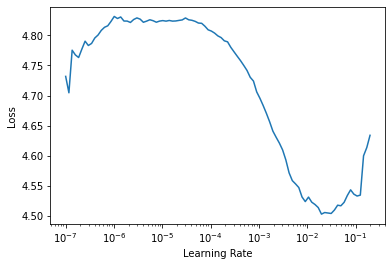

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16877

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.127047,2.837993,0.370959,02:41
1,2.634263,2.472044,0.484375,02:40
2,2.222685,2.153009,0.602910,02:41
3,1.934918,2.068865,0.624731,02:41
4,1.544506,1.566320,0.800647,02:41


epoch,train_loss,valid_loss,accuracy,time
0,3.102160,2.831050,0.387931,02:41
1,2.583418,2.627657,0.458244,02:41
2,2.228616,2.439460,0.516703,02:41
3,1.947141,2.052904,0.628772,02:42
4,1.561787,1.589241,0.789062,02:42


epoch,train_loss,valid_loss,accuracy,time
0,3.150106,2.892642,0.356142,02:42
1,2.616321,2.486427,0.497037,02:42
2,2.236765,2.373377,0.533136,02:41
3,1.975193,2.088197,0.635776,02:41
4,1.568120,1.602488,0.785830,02:41


In [0]:
print(results)

[0.8006465435028076, 0.7890625, 0.7858297228813171]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79185
Accuracy Std: 0.00636


### Exp 3.4: GeM SE reduction=8 - 0.79122

SuggestedLRs(lr_min=0.0010573712177574634, lr_steep=0.0014235129347071052)

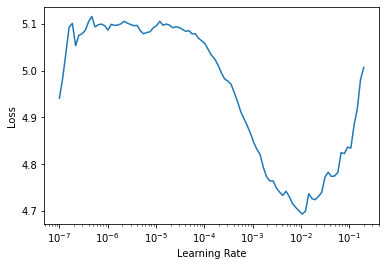

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]], final_pool=GeM())
model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

15117

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]], final_pool=GeM())
    model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.228741,2.862978,0.383351,02:47
1,2.607265,2.547200,0.465517,02:47
2,2.243610,2.197954,0.593211,02:47
3,1.937115,1.947457,0.660291,02:47
4,1.547134,1.584831,0.782866,02:47


epoch,train_loss,valid_loss,accuracy,time
0,3.255786,3.025483,0.344019,02:46
1,2.625066,2.450782,0.491110,02:46
2,2.199240,2.288198,0.554688,02:47
3,1.915658,1.964348,0.647629,02:47
4,1.516855,1.561583,0.794720,02:47


epoch,train_loss,valid_loss,accuracy,time
0,3.306717,3.046661,0.349946,02:47
1,2.616724,2.607542,0.446390,02:47
2,2.222495,2.177919,0.585129,02:47
3,1.914506,2.115705,0.612069,02:47
4,1.540840,1.564896,0.796067,02:47


In [0]:
print(results)

[0.782866358757019, 0.7947198152542114, 0.7960668206214905]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79122
Accuracy Std: 0.00593


### Exp 3.5: GeM SE reduction=16 - 0.79912

SuggestedLRs(lr_min=0.0016795642673969268, lr_steep=0.0012200333876535296)

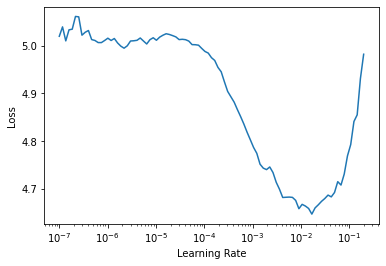

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]], final_pool=GeM())
model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16674

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]], final_pool=GeM())
    model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())
    
    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.120548,2.742629,0.401670,02:47
1,2.510144,2.449643,0.502425,02:47
2,2.152416,2.214208,0.582705,02:47
3,1.857551,1.968904,0.660022,02:47
4,1.471015,1.512583,0.813578,02:47


epoch,train_loss,valid_loss,accuracy,time
0,3.271248,2.922839,0.375000,02:47
1,2.590032,2.528141,0.466056,02:47
2,2.210166,2.274698,0.563308,02:47
3,1.920504,2.043417,0.626886,02:47
4,1.518555,1.551730,0.799838,02:47


epoch,train_loss,valid_loss,accuracy,time
0,3.269110,2.982202,0.378772,02:47
1,2.622109,2.611176,0.457705,02:47
2,2.233610,2.282715,0.563578,02:47
3,1.951499,2.039712,0.636584,02:47
4,1.536843,1.581973,0.783944,02:47


In [0]:
print(results)

[0.8135775923728943, 0.7998383641242981, 0.7839439511299133]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79912
Accuracy Std: 0.01211


## Exp 4: ks=[[3,5], [3,5], [3,5], [3,5]]

### Exp 4.1: Without SE - 0.78233

SuggestedLRs(lr_min=0.0022865252569317816, lr_steep=0.009062286466360092)

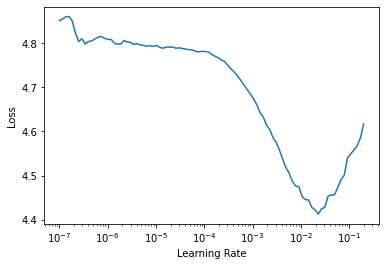

In [0]:
model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5], [3,5], [3,5], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

49935

In [0]:
results = []
for i in range(3):
    model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5], [3,5], [3,5], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.081714,2.914413,0.353987,02:29
1,2.602899,2.580625,0.464978,02:29
2,2.249794,2.350312,0.541756,02:29
3,2.007058,2.052144,0.643588,02:29
4,1.598397,1.621645,0.783136,02:29


epoch,train_loss,valid_loss,accuracy,time
0,3.115062,2.930685,0.347791,02:29
1,2.660672,2.581312,0.461207,02:29
2,2.279490,2.633111,0.463362,02:29
3,2.008702,2.058063,0.625808,02:29
4,1.596995,1.620004,0.790410,02:29


epoch,train_loss,valid_loss,accuracy,time
0,3.168407,3.200921,0.282058,02:29
1,2.684994,2.876823,0.416218,02:29
2,2.328943,2.476245,0.511853,02:29
3,2.032501,2.150289,0.603987,02:29
4,1.641258,1.659924,0.773438,02:29


In [0]:
print(results)

[0.7831357717514038, 0.790409505367279, 0.7734375]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.78233
Accuracy Std: 0.00695


### Exp 4.2: SE reduction=8 - 0.77308

SuggestedLRs(lr_min=0.0022865252569317816, lr_steep=0.004190726205706596)

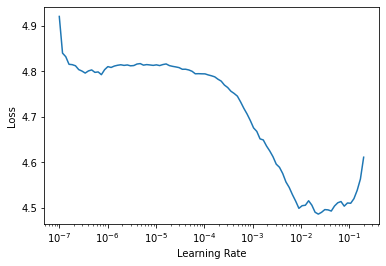

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8,  ks=[[3,5], [3,5], [3,5], [3,5]])
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

17184

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5], [3,5], [3,5]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.122997,2.945236,0.362877,02:37
1,2.579775,2.526103,0.483836,02:37
2,2.276649,2.332647,0.535291,02:37
3,1.979944,2.154878,0.597252,02:37
4,1.594255,1.628286,0.768858,02:37


epoch,train_loss,valid_loss,accuracy,time
0,3.096986,2.850207,0.385506,02:37
1,2.633924,2.505115,0.471713,02:37
2,2.306180,2.385463,0.521282,02:37
3,2.064172,2.268872,0.560075,02:36
4,1.599908,1.634980,0.774515,02:36


epoch,train_loss,valid_loss,accuracy,time
0,3.098764,2.875506,0.381196,02:35
1,2.600825,2.575116,0.443427,02:36
2,2.272983,2.441915,0.512392,02:37
3,2.001487,2.023311,0.636315,02:37
4,1.596897,1.615578,0.775862,02:36


In [0]:
print(results)

[0.7688577771186829, 0.7745150923728943, 0.7758620977401733]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.77308
Accuracy Std: 0.00303


### Exp 4.3: SE reduction=16 - 0.76949

SuggestedLRs(lr_min=0.005769181624054908, lr_steep=0.003078292589634657)

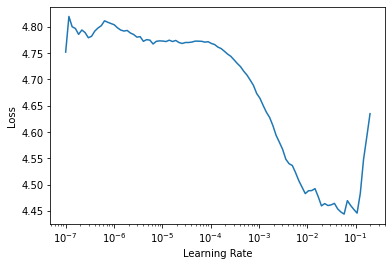

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5], [3,5], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16328

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5], [3,5], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.089881,2.886202,0.368265,02:36
1,2.602166,2.602869,0.474407,02:36
2,2.287733,2.369349,0.545259,02:36
3,1.991007,2.103259,0.605065,02:36
4,1.591171,1.633028,0.779903,02:36


epoch,train_loss,valid_loss,accuracy,time
0,3.172412,3.126374,0.293103,02:36
1,2.687213,2.518399,0.472791,02:36
2,2.308772,2.369784,0.537985,02:36
3,2.055513,2.280577,0.551724,02:36
4,1.660486,1.675870,0.759160,02:36


epoch,train_loss,valid_loss,accuracy,time
0,3.133692,3.070712,0.311153,02:36
1,2.617210,2.587123,0.463631,02:36
2,2.273026,2.263211,0.564116,02:36
3,2.023312,2.012946,0.644935,02:36
4,1.613312,1.641831,0.769397,02:36


In [0]:
print(results)

[0.779902994632721, 0.759159505367279, 0.7693965435028076]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.76949
Accuracy Std: 0.00847


## Exp 5: ks=[[3,5], [3,5], [3,5], [3]]

### Exp 5.1: : Without SE - 0.77281

SuggestedLRs(lr_min=0.003631993755698204, lr_steep=0.004190726205706596)

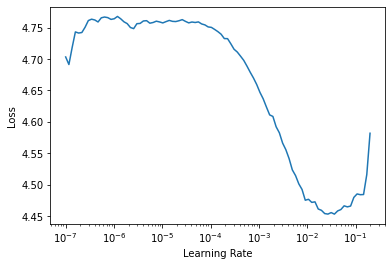

In [0]:
model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5], [3,5], [3,5], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16035

In [0]:
results = []
for i in range(3):
    model = mk_resnext50d(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5], [3,5], [3,5], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.169145,2.976304,0.346983,02:26
1,2.681859,2.633453,0.451509,02:26
2,2.364605,2.223044,0.568696,02:27
3,2.070730,2.071815,0.628233,02:27
4,1.655330,1.646950,0.775862,02:27


epoch,train_loss,valid_loss,accuracy,time
0,3.137223,2.913522,0.371228,02:27
1,2.613257,2.494588,0.481412,02:27
2,2.314785,2.747070,0.439386,02:26
3,2.084711,2.188871,0.611530,02:26
4,1.650215,1.679253,0.761853,02:26


epoch,train_loss,valid_loss,accuracy,time
0,3.132718,3.095907,0.346444,02:26
1,2.630924,2.761883,0.410022,02:26
2,2.292236,2.485619,0.500808,02:26
3,2.028273,2.214003,0.585129,02:26
4,1.622238,1.634156,0.780711,02:26


In [0]:
print(results)

[0.7758620977401733, 0.7618534564971924, 0.7807112336158752]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.77281
Accuracy Std: 0.00800


### Exp 5.2: SE reduction=8 - 0.77514

SuggestedLRs(lr_min=0.004944524168968201, lr_steep=0.0014235129347071052)

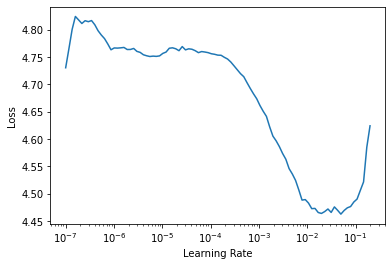

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8,  ks=[[3,5], [3,5], [3,5], [3]])
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16231

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5], [3,5], [3]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.170109,2.885324,0.370151,02:35
1,2.661318,2.649638,0.435614,02:35
2,2.328189,2.405333,0.528017,02:35
3,2.044358,2.145875,0.599946,02:35
4,1.592703,1.614715,0.780172,02:35


epoch,train_loss,valid_loss,accuracy,time
0,3.099706,2.881285,0.368265,02:35
1,2.624389,2.572120,0.471983,02:35
2,2.251489,2.389587,0.538254,02:35
3,2.005481,2.145510,0.606950,02:35
4,1.608193,1.647492,0.768319,02:35


epoch,train_loss,valid_loss,accuracy,time
0,3.064182,2.919596,0.356412,02:35
1,2.581854,2.523867,0.461476,02:35
2,2.314796,2.285323,0.551724,02:35
3,2.034294,2.299036,0.540948,02:35
4,1.610028,1.636448,0.776940,02:35


In [0]:
print(results)

[0.7801724076271057, 0.7683189511299133, 0.7769396305084229]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.77514
Accuracy Std: 0.00500


### Exp 5.3: SE reduction=16 - 0.76913

SuggestedLRs(lr_min=0.0031128300353884695, lr_steep=0.004190726205706596)

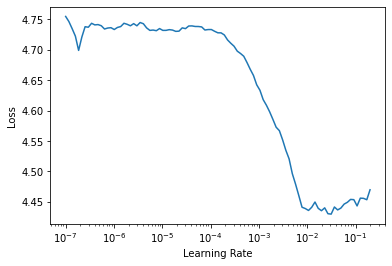

In [0]:
model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5], [3,5], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16173

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50d(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5], [3,5], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.123580,2.960905,0.339440,02:35
1,2.652671,2.614820,0.446929,02:35
2,2.295011,2.284657,0.558998,02:35
3,2.016073,2.211187,0.577856,02:35
4,1.622808,1.633463,0.776401,02:35


epoch,train_loss,valid_loss,accuracy,time
0,3.140696,2.930599,0.355334,02:35
1,2.650747,2.573449,0.464440,02:35
2,2.331987,2.493880,0.495690,02:35
3,2.066316,2.163304,0.607759,02:35
4,1.635422,1.654515,0.762662,02:35


epoch,train_loss,valid_loss,accuracy,time
0,3.090240,2.807057,0.385506,02:35
1,2.605455,2.561589,0.473869,02:35
2,2.281496,2.432360,0.505388,02:35
3,2.017641,2.203547,0.576509,02:35
4,1.624714,1.635163,0.768319,02:35


In [0]:
print(results)

[0.7764008641242981, 0.7626616358757019, 0.7683189511299133]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.76913
Accuracy Std: 0.00564


# MK-ResNeXt-50E

## Exp 6: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]]

### Exp 6.1: No SE - 0.79957

SuggestedLRs(lr_min=0.0022865252569317816, lr_steep=0.003078292589634657)

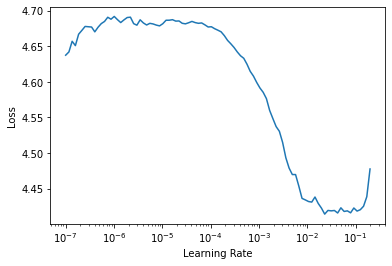

In [0]:
model = mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]], iks=[3,5])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

14457

In [0]:
results = []
for i in range(3):
    model = mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.113307,2.826853,0.383621,03:04
1,2.548049,2.425363,0.516703,03:04
2,2.137023,2.247930,0.586207,03:04
3,1.914511,1.877627,0.697198,03:04
4,1.504369,1.527821,0.809806,03:04


epoch,train_loss,valid_loss,accuracy,time
0,3.071695,2.810822,0.386853,03:04
1,2.574164,2.525896,0.481681,03:04
2,2.186146,2.294979,0.552532,03:04
3,1.930479,2.117803,0.622575,03:04
4,1.569911,1.591681,0.787985,03:04


epoch,train_loss,valid_loss,accuracy,time
0,3.083707,2.856535,0.383890,03:04
1,2.593759,2.462140,0.493265,03:05
2,2.200888,2.341894,0.542834,03:04
3,1.931772,2.094158,0.627425,03:04
4,1.529248,1.570128,0.800916,03:04


In [0]:
print(results)

[0.8098060488700867, 0.7879849076271057, 0.8009159564971924]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79957
Accuracy Std: 0.00896


### Exp 6.2: SE reduction=8 - 0.78682

SuggestedLRs(lr_min=0.0026678763329982757, lr_steep=0.003078292589634657)

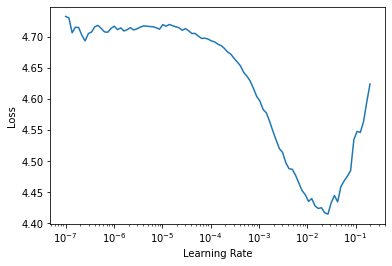

In [0]:
model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16889

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.067828,3.191953,0.322737,03:08
1,2.495054,2.421484,0.509429,03:08
2,2.165898,2.286942,0.559537,03:08
3,1.887154,1.948201,0.668642,03:08
4,1.518996,1.557347,0.801185,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.102490,2.851916,0.375000,03:08
1,2.592129,2.447649,0.500539,03:08
2,2.240215,2.140913,0.600485,03:08
3,1.989795,2.000683,0.644935,03:08
4,1.577050,1.594716,0.783944,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.091730,2.836128,0.393858,03:08
1,2.602366,2.512266,0.490032,03:08
2,2.254391,2.245802,0.567619,03:08
3,1.985981,2.021108,0.639278,03:08
4,1.587776,1.613233,0.775323,03:08


In [0]:
print(results)

[0.8011853694915771, 0.7839439511299133, 0.7753232717514038]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.78682
Accuracy Std: 0.01075


### Exp 6.3: SE reduction=16 - 0.80370

SuggestedLRs(lr_min=0.0026678763329982757, lr_steep=0.002638275967910886)

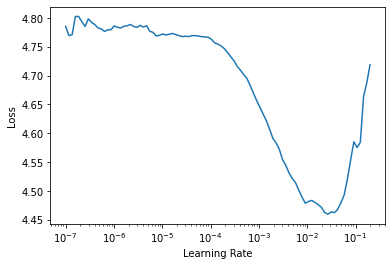

In [0]:
model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16169

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.073694,2.728789,0.418912,03:08
1,2.504948,2.418894,0.508082,03:08
2,2.152014,2.185699,0.592942,03:08
3,1.886975,1.972872,0.662177,03:08
4,1.508259,1.533430,0.811692,03:09


epoch,train_loss,valid_loss,accuracy,time
0,3.090557,2.965471,0.343481,03:08
1,2.554508,2.531446,0.470097,03:09
2,2.242272,2.370568,0.539601,03:09
3,1.952244,1.966033,0.651401,03:09
4,1.535804,1.566188,0.798222,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.064933,2.822206,0.398168,03:08
1,2.540462,2.457499,0.495420,03:08
2,2.210973,2.240880,0.567080,03:08
3,1.935325,1.941714,0.659752,03:08
4,1.517775,1.551842,0.801185,03:08


In [0]:
print(results)

[0.8116918206214905, 0.798222005367279, 0.8011853694915771]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.80370
Accuracy Std: 0.00578


## Exp 7: ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]]

### Exp 7.1: No SE - 0.79265

SuggestedLRs(lr_min=0.0016795642673969268, lr_steep=0.004190726205706596)

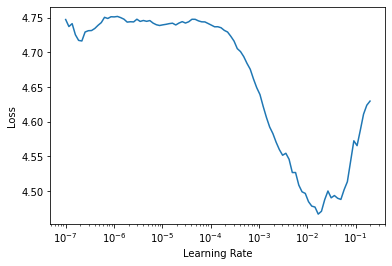

In [0]:
model = mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

32018

In [0]:
results = []
for i in range(3):
    model = mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.137738,2.865614,0.375539,03:15
1,2.594958,2.499478,0.488685,03:15
2,2.250916,2.219500,0.577047,03:15
3,1.965830,2.071929,0.633351,03:15
4,1.554202,1.585758,0.794450,03:15


epoch,train_loss,valid_loss,accuracy,time
0,3.128896,2.884804,0.366379,03:15
1,2.533523,2.480563,0.511584,03:15
2,2.212836,2.348022,0.535291,03:15
3,1.937684,2.063732,0.623653,03:15
4,1.526938,1.570993,0.793373,03:16


epoch,train_loss,valid_loss,accuracy,time
0,3.135162,2.873665,0.360991,03:15
1,2.602006,2.389184,0.519127,03:16
2,2.229833,2.353544,0.526940,03:16
3,1.911839,1.934703,0.666218,03:16
4,1.518341,1.567351,0.790140,03:16


In [0]:
print(results)

[0.7944504022598267, 0.7933728694915771, 0.7901400923728943]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79265
Accuracy Std: 0.00183


### Exp 7.2: SE reduction=8 - 0.79445

SuggestedLRs(lr_min=0.0010573712177574634, lr_steep=0.0012200333876535296)

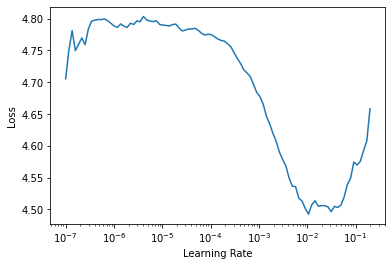

In [0]:
model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

17245

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.125200,2.865666,0.362338,03:19
1,2.545994,2.418417,0.509429,03:19
2,2.230751,2.239195,0.568157,03:19
3,1.943497,2.042775,0.624192,03:20
4,1.525943,1.558774,0.798222,03:20


epoch,train_loss,valid_loss,accuracy,time
0,3.122280,2.882148,0.372037,03:20
1,2.591477,2.449642,0.502425,03:20
2,2.253953,2.335028,0.546067,03:19
3,1.937943,1.976933,0.664871,03:20
4,1.536238,1.558949,0.800647,03:20


epoch,train_loss,valid_loss,accuracy,time
0,3.085786,2.936054,0.359106,03:19
1,2.615783,2.569228,0.463901,03:19
2,2.238255,2.292150,0.549300,03:19
3,1.971251,2.024774,0.643858,03:19
4,1.578967,1.598308,0.784483,03:20


In [0]:
print(results)

[0.798222005367279, 0.8006465435028076, 0.7844827771186829]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79445
Accuracy Std: 0.00712


### Exp 7.3: SE reduction=16 - 0.80406

SuggestedLRs(lr_min=0.0019596852362155914, lr_steep=0.0012200333876535296)

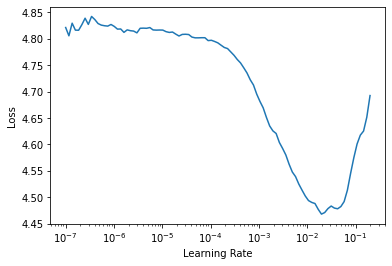

In [0]:
model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

17361

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.080781,2.879455,0.363147,03:20
1,2.555544,2.674283,0.448545,03:19
2,2.140912,2.202375,0.590517,03:20
3,1.866492,2.004817,0.653556,03:20
4,1.499064,1.523794,0.814386,03:19


epoch,train_loss,valid_loss,accuracy,time
0,3.160509,2.954986,0.331358,03:19
1,2.593655,2.857580,0.426455,03:20
2,2.175620,2.198183,0.579472,03:20
3,1.924102,1.993391,0.657058,03:20
4,1.527876,1.565108,0.799838,03:20


epoch,train_loss,valid_loss,accuracy,time
0,3.145663,2.927090,0.358567,03:19
1,2.597101,2.422907,0.502694,03:20
2,2.192541,2.446418,0.507274,03:20
3,1.922392,1.917675,0.672414,03:20
4,1.539213,1.571859,0.797953,03:20


In [0]:
print(results)

[0.8143857717514038, 0.7998383641242981, 0.7979525923728943]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.80406
Accuracy Std: 0.00734


## Exp 8: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]]

### Exp 8.1: No SE - 0.80163

SuggestedLRs(lr_min=0.0019596852362155914, lr_steep=0.004190726205706596)

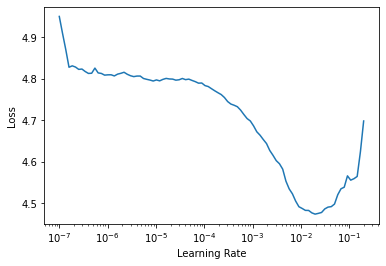

In [0]:
model = mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda,  ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

14431

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.087385,2.873141,0.356950,03:10
1,2.569565,2.488718,0.491918,03:06
2,2.185071,2.161051,0.585938,03:06
3,1.924814,1.989448,0.648976,03:06
4,1.552104,1.572851,0.796875,03:06


epoch,train_loss,valid_loss,accuracy,time
0,3.121119,2.765845,0.410830,03:06
1,2.541546,2.467187,0.505119,03:06
2,2.162544,2.275553,0.563039,03:06
3,1.915680,1.946344,0.664601,03:06
4,1.534063,1.560182,0.806035,03:06


epoch,train_loss,valid_loss,accuracy,time
0,3.094917,2.789370,0.376616,03:05
1,2.549702,2.589645,0.455819,03:06
2,2.193147,2.188125,0.596444,03:06
3,1.906240,2.043635,0.636853,03:06
4,1.527658,1.561869,0.801994,03:06


In [0]:
print(results)

[0.796875, 0.806034505367279, 0.8019935488700867]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.80163
Accuracy Std: 0.00375


### Exp 8.2: SE reduction=8 - 0.79822

SuggestedLRs(lr_min=0.01247563660144806, lr_steep=0.005705171264708042)

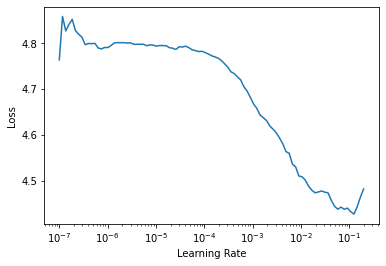

In [0]:
model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16416

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.082685,2.723862,0.405442,03:06
1,2.524431,2.667001,0.457166,03:06
2,2.138506,2.166621,0.596713,03:06
3,1.871974,1.940935,0.661099,03:06
4,1.521651,1.551171,0.810075,03:06


epoch,train_loss,valid_loss,accuracy,time
0,3.079334,2.793592,0.390356,03:06
1,2.514320,2.498090,0.474677,03:06
2,2.166398,2.217293,0.575970,03:06
3,1.900171,2.107779,0.624192,03:06
4,1.519956,1.540952,0.800108,03:06


epoch,train_loss,valid_loss,accuracy,time
0,3.157321,2.831638,0.377963,03:06
1,2.603862,2.624751,0.462554,03:06
2,2.272595,2.417744,0.534752,03:06
3,2.009704,2.101357,0.615302,03:06
4,1.591750,1.619239,0.784483,03:06


In [0]:
print(results)

[0.8100754022598267, 0.8001077771186829, 0.7844827771186829]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.79822
Accuracy Std: 0.01053


### Exp 8.3: SE reduction=16 - 0.78807

SuggestedLRs(lr_min=0.0016795642673969268, lr_steep=0.0012200333876535296)

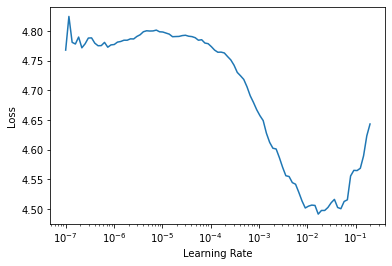

In [0]:
model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

15689

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50e(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.088392,2.935446,0.334591,03:00
1,2.539306,2.578104,0.462015,03:00
2,2.151114,2.491930,0.491649,03:00
3,1.904337,2.004016,0.648438,03:00
4,1.518227,1.553648,0.804688,03:00


epoch,train_loss,valid_loss,accuracy,time
0,3.131795,2.910487,0.378233,02:59
1,2.600096,2.553258,0.476024,03:00
2,2.236933,2.253818,0.577047,03:00
3,1.981626,2.079439,0.604256,03:00
4,1.566251,1.592575,0.788254,03:00


epoch,train_loss,valid_loss,accuracy,time
0,3.112865,2.810633,0.378772,03:00
1,2.608945,2.478481,0.498384,03:00
2,2.259454,2.214943,0.575162,02:59
3,1.972535,2.096383,0.626886,02:59
4,1.603022,1.631523,0.771282,02:59


In [0]:
print(results)

[0.8046875, 0.7882543206214905, 0.7712823152542114]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.78807
Accuracy Std: 0.01364
